In [1]:
from fastai import *
from fastai.vision import *

from astroML.crossmatch import crossmatch_angular

PATH = Path('../..').resolve()

seed = 12345

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

slope = lambda y, p: ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

Mish activation loaded...
Mish activation loaded...


In [3]:
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

# Load data

## Get 100% ALFALFA catalog

In [31]:
df = pd.read_csv(f"{PATH}/data/a100.code12.tab1.180315.csv")
df.shape

(31502, 19)

In [32]:
ids = np.array([o.stem for o in (PATH/'images-OC/').glob('*.jpg')], dtype=int)
len(ids)

30305

In [33]:
df = df.set_index('AGCNr').loc[ids].reset_index()
df.head(3)

,AGCNr,Name,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist,sigDist,logMH,siglogMH,HIcode
0,204049,........,150.68210,4.03889,150.69000,4.04528,16779,68,17,165,0.84,0.06,9.6,2.35,244.6,2.3,10.07,0.05,1
1,246116,........,221.30583,29.63750,221.31459,29.63583,8887,244,70,113,0.87,0.09,5.2,2.39,129.3,2.3,9.54,0.06,2
2,4626,........,132.75293,24.31944,132.75458,24.31917,2732,103,2,127,6.17,0.06,59.2,2.28,41.0,2.1,9.39,0.06,1


## Crossmatch a.100 with 700k Sloan galaxies

In [36]:
sdss = pd.read_csv(f"{PATH}/data/SDSS_basic_data.csv")
sdss.columns

Index(['objID', 'DR7ObjID', 'specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp',
       'velDispErr', 'modelMag_u', 'modelMagErr_u', 'modelMag_g',
       'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i',
       'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r',
       'petroR90_r', 'bptclass', 'oh_p16', 'oh_p50', 'oh_p84', 'lgm_tot_p16',
       'lgm_tot_p50', 'lgm_tot_p84', 'sfr_tot_p16', 'sfr_tot_p50',
       'sfr_tot_p84'],
      dtype='object')

In [37]:
sdss.shape

(717778, 31)

In [45]:
_, ind = crossmatch_angular(
    df[['RAdeg_OC', 'DECdeg_OC']].values, 
    sdss[['ra', 'dec']].values, 
    max_distance=1./3600
)

In [46]:
sum(ind == len(sdss))

18152

In [65]:
sdss_matches = sdss.loc[list(i for i in ind if i != len(sdss))]
sdss_matches.shape

(12153, 31)

In [68]:
sdss_matches = sdss_matches[['lgm_tot_p50', 'sfr_tot_p50', 'oh_p50', 'z', 'objID', 'DR7ObjID', 'specObjID']]
sdss_matches.set_index(df.AGCNr.loc[ind != len(sdss)], inplace=True)
sdss_matches.sample(3)

,lgm_tot_p50,sfr_tot_p50,oh_p50,z,objID,DR7ObjID,specObjID
AGCNr,,,,,,,
261196,9.617785,-0.199806,8.627328,0.033578,1237665532796993696,587739811572089005,2473691490296031232
122326,10.309060,-0.430009,-9999.000000,0.049226,1237649921120600218,587724199895695473,481997616784107520
741131,9.025846,-0.345637,8.477970,0.031331,1237667735041081479,587742013816176759,2814921361015728128


## Get clean sample (crossmatched, HIcode = 1)

In [69]:
df_clean = df.loc[ind != len(sdss)]
df_clean.shape

(12153, 19)

In [71]:
df = df_clean.join(sdss_matches, on='AGCNr')

In [72]:
df.sample(10)

,AGCNr,Name,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,...,logMH,siglogMH,HIcode,lgm_tot_p50,sfr_tot_p50,oh_p50,z,objID,DR7ObjID,specObjID
29252,263827,........,243.58626,25.24889,243.58832,25.24917,9915,220,55,95,...,9.73,0.05,1,9.262413,-0.434341,8.641956,0.033025,1237662306201501856,587736584976597174,1773356183554385920
15392,122337,........,32.65917,13.96222,32.63875,13.96250,12376,185,6,98,...,10.00,0.05,1,9.985728,0.048421,8.961385,0.041315,1237649920583794862,587724199358890184,482012735068989440
2419,732019,........,183.67751,24.97778,183.67667,24.98056,6582,227,31,354,...,9.38,0.06,1,9.885159,0.178958,8.989938,0.022050,1237667447266213910,587741726041309213,2991566430668875776
2320,217466,........,169.69376,21.44333,169.68042,21.45639,9680,106,9,223,...,9.42,0.07,2,9.034281,-0.516061,8.608225,0.032306,1237667782291620073,587742061066715281,2805751983795890176
17008,244282,........,216.30833,7.96611,216.30125,7.96972,7893,193,10,143,...,9.16,0.07,2,8.822333,-1.353492,8.479797,0.026068,1237662236943122913,588017990694928600,2039007814222899200
19558,10064,136-098.,237.80460,25.70222,237.80542,25.70194,6399,287,47,135,...,9.61,0.05,1,10.792370,-1.561937,-9999.000000,0.021468,1237664854190194710,587739132965290012,2083067448415774720
17241,112738,........,18.16708,15.14389,18.16542,15.14556,12635,261,35,269,...,9.98,0.06,1,9.186096,-0.348869,8.404689,0.042223,1237666214607126795,758877279222300967,475293068547876864
2231,252206,051-006.,238.97585,4.83556,238.96877,4.83389,7754,258,6,119,...,9.59,0.06,1,10.242430,-0.073571,-9999.000000,0.025725,1237662268078882947,587736546853978300,3322668690842871808
20865,172700,........,118.29166,16.61361,118.29791,16.60361,16246,133,8,159,...,10.11,0.06,1,10.230090,0.058042,-9999.000000,0.054177,1237664835921969613,587739114697064921,2162899406427285504
17464,268142,........,242.60167,10.20278,242.59833,10.21083,5069,136,5,100,...,9.13,0.06,1,8.811203,-0.456119,8.609987,0.016875,1237668350295408819,587742629070504136,2844174424406517760


In [74]:
df['logfgas'] = df.logMH - df.lgm_tot_p50

In [81]:
df = df.loc[df.lgm_tot_p50 > 0]
df.shape

(12114, 27)

In [82]:
# df.to_csv(f'{PATH}/data/a.100_SDSS.csv', index=False)

## Load cleaned df

In [4]:
df = pd.read_csv(f'{PATH}/data/a.100_SDSS.csv')

# Train

In [5]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)

## 100 epochs with mxresnet50

In [9]:
model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [10]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [86]:
learn.fit_one_cycle(100, 3e-2)

epoch,train_loss,valid_loss,time
0,0.334868,0.374875,01:20
1,0.318773,0.351149,01:19
2,0.300274,0.290201,01:19
3,0.290564,0.280401,01:19
4,0.285269,0.348088,01:19
5,0.295833,0.307871,01:19
6,0.292536,0.285510,01:19
7,0.294367,0.410509,01:19
8,0.278475,0.348182,01:19
9,0.288820,0.298898,01:19


In [87]:
# learn.save('a.100-mxresnet50-100')

## 40 epochs with mxresnet34

In [11]:
model = mxresnet34()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [12]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

epoch,train_loss,valid_loss,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


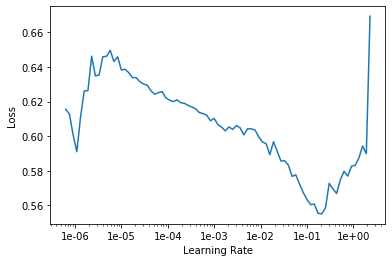

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,time
0,0.403428,0.374632,00:45
1,0.333539,0.332778,00:45
2,0.282788,0.289303,00:45
3,0.305170,0.285390,00:45
4,0.302047,0.306608,00:45
5,0.284199,0.264683,00:45
6,0.316059,0.409688,00:45
7,0.297657,0.296611,00:45
8,0.305037,0.334980,00:45
9,0.310906,0.417095,00:45


In [13]:
# learn.save('a.100-mxresnet34-40')
learn = learn.load('a.100-mxresnet34-40');

set state called


# Results

In [15]:
data.valid_ds.tfms

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

In [16]:
preds, trues = learn.TTA(scale=1.)

In [21]:
res_df = pd.DataFrame({'fgas_true': trues.flatten(), 'fgas_pred': preds.flatten()})

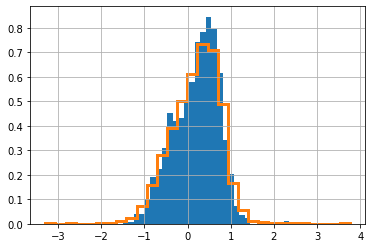

In [22]:
res_df.fgas_pred.hist(bins=30, density=True)
res_df.fgas_true.hist(bins=30, density=True, histtype='step', lw=3)

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

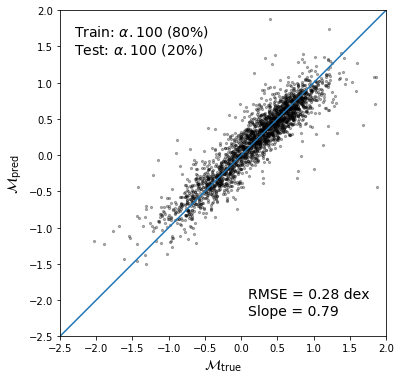

In [23]:
plt.figure(figsize=(6, 6))

plt.scatter(res_df.fgas_true, res_df.fgas_pred, c='k', s=5, alpha=0.3)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.100$ (80%)' + '\n' +r'Test: $\alpha.100$ (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((res_df.fgas_true - res_df.fgas_pred)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(res_df.fgas_true, res_df.fgas_pred):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)